In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)
n_customers = 200

age = np.random.randint(18, 70, n_customers)
annual_income = np.random.normal(50000, 20000, n_customers)
spending_score = np.random.randint(1, 100, n_customers)
gender = np.random.choice(['Male', 'Female'], n_customers)

data = {
    'CustomerID': range(1, n_customers + 1),
    'Gender': gender,
    'Age': age,
    'Annual Income (k$)': annual_income / 1000,
    'Spending Score (1-100)': spending_score
}

df = pd.DataFrame(data)
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Female,56,52.540245,75
1,2,Female,69,25.011126,29
2,3,Female,46,88.902312,36
3,4,Male,32,46.933271,89
4,5,Male,60,31.860255,21


In [3]:
print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
df.info()

Dataset shape: (200, 5)
Missing values: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerID              200 non-null    int64  
 1   Gender                  200 non-null    object 
 2   Age                     200 non-null    int32  
 3   Annual Income (k$)      200 non-null    float64
 4   Spending Score (1-100)  200 non-null    int32  
dtypes: float64(1), int32(2), int64(1), object(1)
memory usage: 6.4+ KB


In [4]:
df['Annual Income (k$)'] = df['Annual Income (k$)'].clip(lower=15, upper=140)
df = df.dropna()
df = df.drop_duplicates()
df['Gender_encoded'] = df['Gender'].map({'Male': 0, 'Female': 1})

In [5]:
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X = df[features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

In [7]:
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)
df['Cluster'] = cluster_labels

In [8]:
final_silhouette = silhouette_score(X_scaled, cluster_labels)
print(f"Final Silhouette Score: {final_silhouette:.3f}")
print(f"Number of clusters: {optimal_k}")
print(f"Inertia: {kmeans_final.inertia_:.2f}")

Final Silhouette Score: 0.267
Number of clusters: 4
Inertia: 273.80


In [9]:
cluster_summary = df.groupby('Cluster')[features].agg(['mean', 'std']).round(2)
print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
           Age       Annual Income (k$)        Spending Score (1-100)       
          mean   std               mean    std                   mean    std
Cluster                                                                     
0        35.33  9.89              45.17  17.37                  24.64  13.79
1        56.47  7.46              37.17  12.76                  58.04  20.43
2        55.48  9.91              74.61  12.96                  37.59  27.03
3        28.74  8.19              48.05  17.28                  79.59  15.19


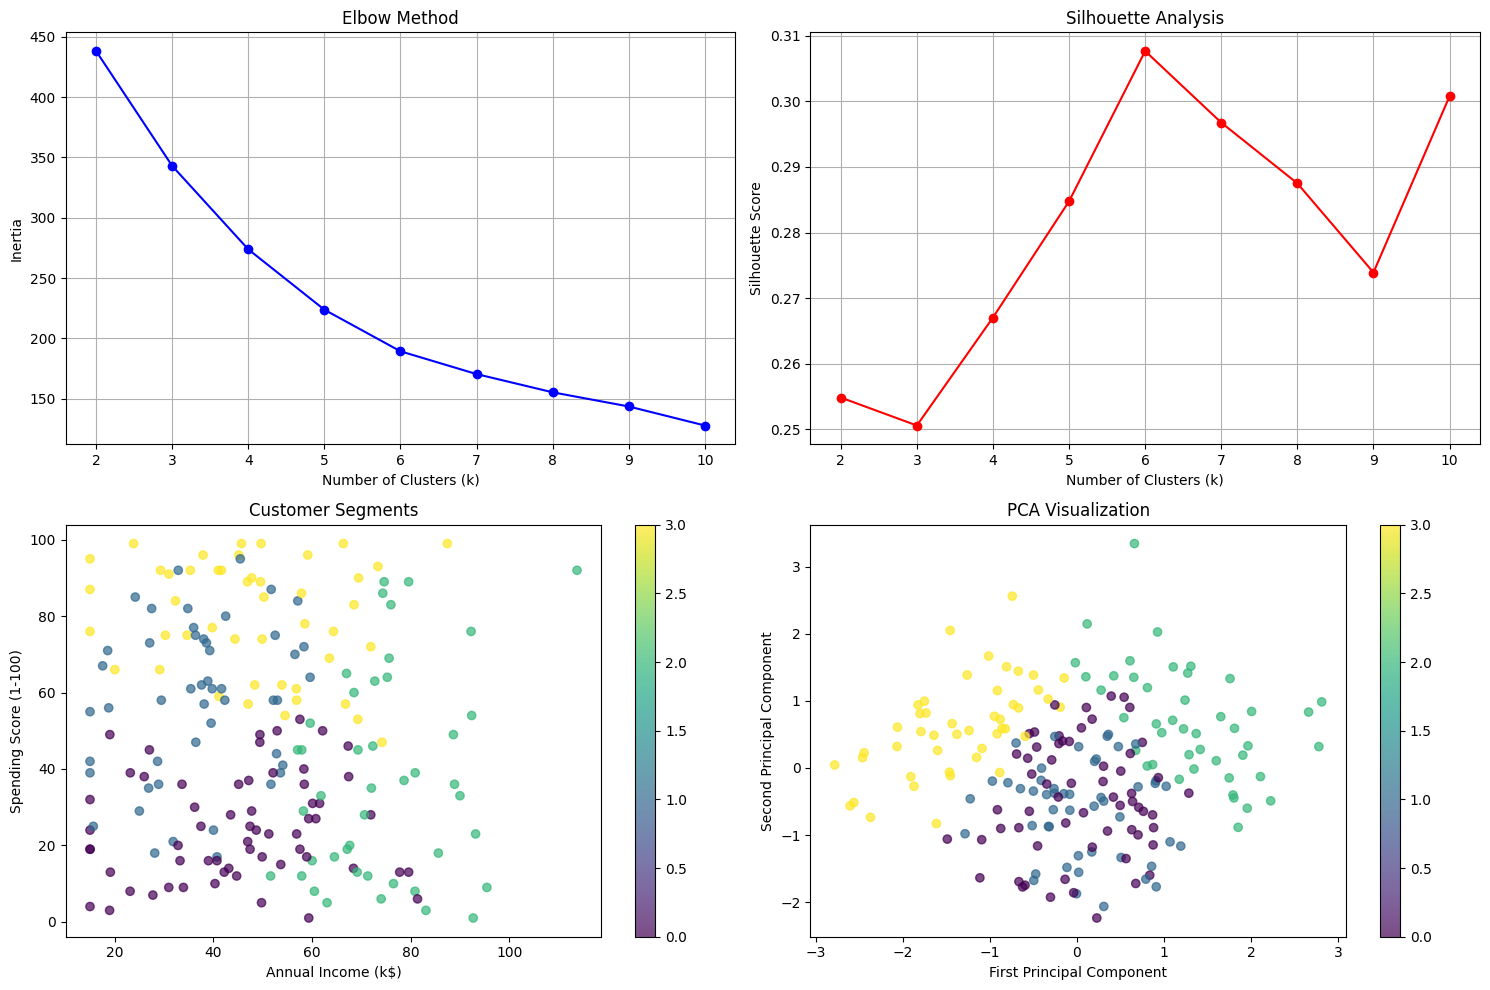

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(k_range, inertias, 'bo-')
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].set_title('Elbow Method')
axes[0, 0].grid(True)

axes[0, 1].plot(k_range, silhouette_scores, 'ro-')
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Analysis')
axes[0, 1].grid(True)

scatter = axes[1, 0].scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], 
                           c=df['Cluster'], cmap='viridis', alpha=0.7)
axes[1, 0].set_xlabel('Annual Income (k$)')
axes[1, 0].set_ylabel('Spending Score (1-100)')
axes[1, 0].set_title('Customer Segments')
plt.colorbar(scatter, ax=axes[1, 0])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
scatter2 = axes[1, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='viridis', alpha=0.7)
axes[1, 1].set_xlabel('First Principal Component')
axes[1, 1].set_ylabel('Second Principal Component')
axes[1, 1].set_title('PCA Visualization')
plt.colorbar(scatter2, ax=axes[1, 1])

plt.tight_layout()
plt.show()

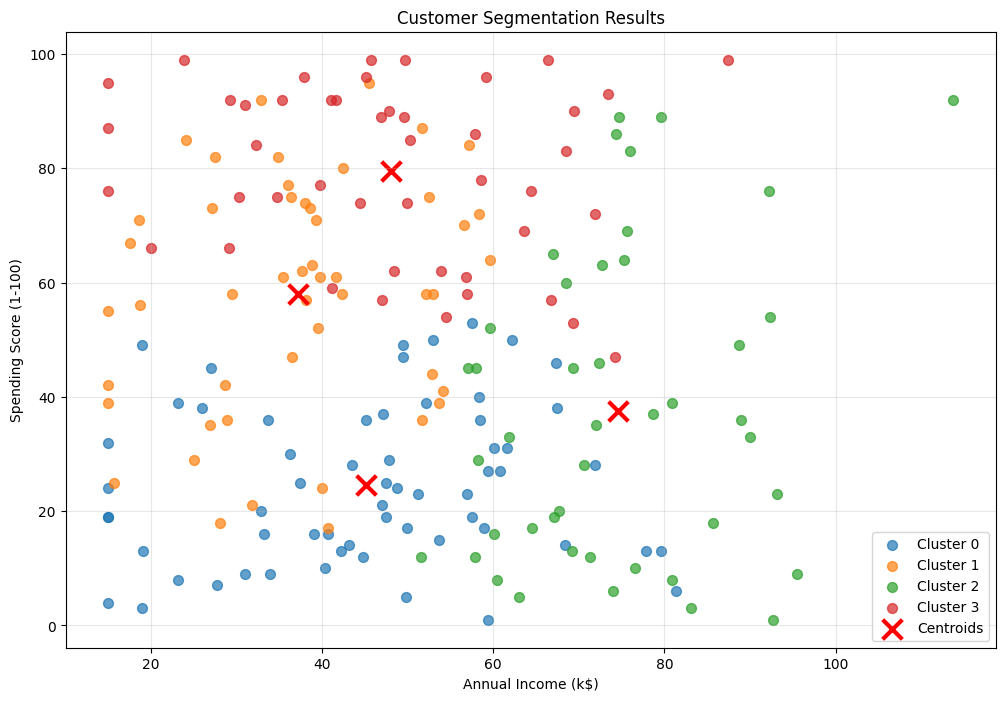

In [11]:
plt.figure(figsize=(12, 8))
for cluster in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster]
    plt.scatter(cluster_data['Annual Income (k$)'], cluster_data['Spending Score (1-100)'], 
               label=f'Cluster {cluster}', alpha=0.7, s=50)

centers_original = scaler.inverse_transform(kmeans_final.cluster_centers_)
plt.scatter(centers_original[:, 1], centers_original[:, 2], 
           c='red', marker='x', s=200, linewidths=3, label='Centroids')

plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Customer Segmentation Results')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()